In [17]:
import pandas as pd
import tarfile
import tqdm
import cv2
import os

In [18]:
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"

In [19]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [20]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [21]:
import numpy as np
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

C:\Users\Iishi\anaconda3\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [22]:
X = X.astype('float32') / 255.0 - 0.5

In [23]:
print(X.max(), X.min())

0.5 -0.5


In [24]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

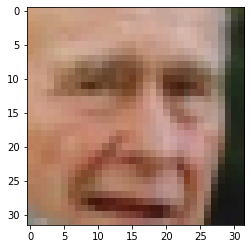

In [25]:
show_image(X[6])

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [27]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

Using TensorFlow backend.
C:\Users\Iishi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Iishi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Iishi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Iishi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [28]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              3073000   
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])


Train on 11828 samples, validate on 1315 samples
Epoch 1/20
11828/11828 [==============================] - 48s 4ms/step - loss: 0.0098 - val_loss: 0.0047
Epoch 2/20
11828/11828 [==============================] - 52s 4ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 3/20
11828/11828 [==============================] - 49s 4ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/20
11828/11828 [==============================] - 51s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/20
11828/11828 [==============================] - 53s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/20
11828/11828 [==============================] - 57s 5ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/20
11828/11828 [==============================] - 53s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/20
11828/11828 [==============================] - 45s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/20
11828/11828 [==============================] - 55s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch

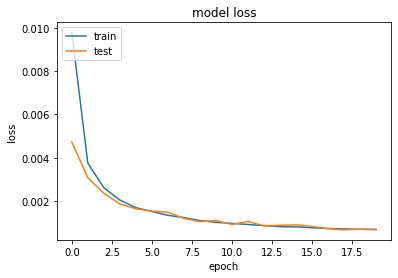

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

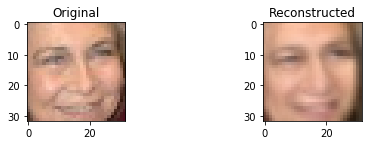

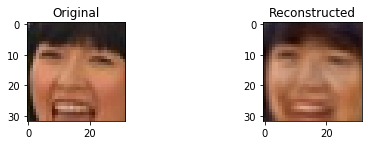

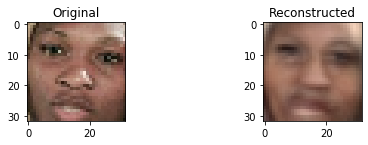

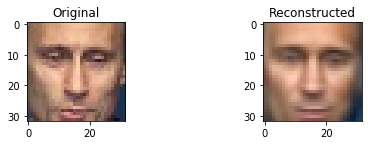

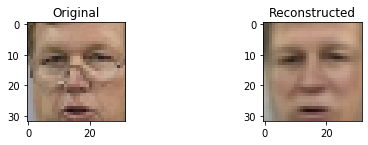

In [38]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
#     kernel = np.array([[-1,-1,-1], 
#                    [-1, 9,-1],
#                    [-1,-1,-1]])
#     image_sharp = cv2.filter2D(reco, -1, kernel)

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

#     plt.subplot(1,3,2)
#     plt.title("Code")
#     plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()
    

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [32]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

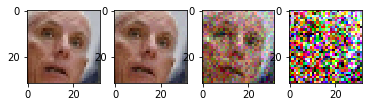

In [33]:
plt.subplot(1,4,1)
show_image(X_train[763])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[763:764],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[763:764],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[763:764],sigma=0.5)[0])

In [34]:
code_size = 100

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

Epoch 1/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 4s 360us/step - loss: 0.0117 - val_loss: 0.0074
Epoch 2/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 4s 352us/step - loss: 0.0063 - val_loss: 0.0054
Epoch 3/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 4s 354us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 4s 352us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 4s 355us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/25

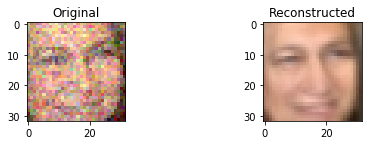

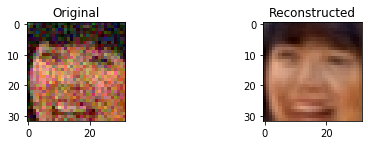

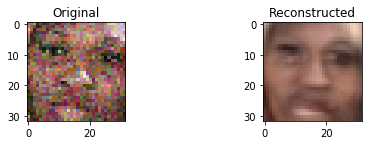

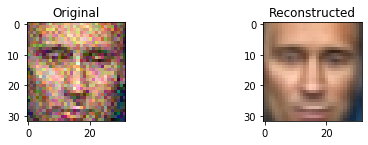

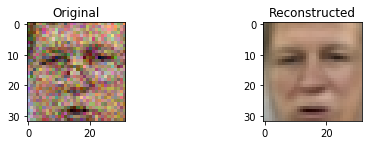

In [39]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)